<a href="https://colab.research.google.com/github/shaye059/Machine-Learning-Stock-Prediction/blob/master/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

**Update: I've come to the realization that the baseline model will probably never be able to learn on the size of dataset I can possibly extract. Instead of the approach mentioned here, I'm going to instead feed the sentences to a sentence encoder and then input those encodings into an XGboost model to perform the regression. I can perhaps experiment with some pre-trained sentiment encoders as well if I find the model still isn't able to learn anything.**

The idea of this project is to be able to predict stock price movement based on news articles. I'll be looking at the stock price from just before the article was published and then comparing it to a few hours after. The theory is that news takes time to dissipate to all share holders so if this model can predict the affect of a news article on the price several hours later, someone could decide to buy or short the stock based on that prediction.

I'll be starting out with a baseline model where I'll lemmatize the sentences and remove common words like "the" and "a'. From there I'll convert the sentences into sparse arrays and then attempt to train a model based on those.

~~Afterward, I'll expirement with preprocessing the sentences through sentence encoders and using different models.~~ This is now the current plan due to the size of the dataset I'll be able to scrape.

#Coding

In [ ]:
!pip install newsapi-python
!pip install -q wordcloud
!pip install yfinance
!pip install -q git+https://github.com/tensorflow/docs

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=9b26d5bd0d5198a36f9fd3bb242be7db3eac7b182cb8f5f5dd1c72f5cb9744bd
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
import wordcloud

from newsapi import NewsApiClient
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import sys
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
import re

import pandas as pd
from datetime import date, timedelta
import yfinance as yf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


##Step 1 - Data extraction
Call the Google News API to get a list of articles for each company in a list. Since the model will be prediciting the effects of news stories, the companies should be as large as possible to ensure a greater variation in who holds stock, which in turn will mean a longer time for the news to spread to most shareholders. I'll also be limiting the companies to the tech sector to make it easier for the model to find trends in articles.

I've written the articles to a CSV file so that this portion does not need to be rerun unless you want to modify the companies or get an updated list of articles.

#### Don't run this section unless you modify the list of companies or want updated articles
I've saved the values into a CSV file that they can be read from.

If you do want to run this section you need a News API key.

-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

In [ ]:

newsapi = NewsApiClient(api_key=) #Your Key Here

list_of_articles = []
dict_of_companies = {'Microsoft': 'MSFT','Apple':'AAPL','Amazon':'AMZN',
                     'Alphabet':'GOOGL','Facebook':'FB','Intel':'INTC',
                     'Cisco Systems':'CSCO','Comcast':'CMCSA','Adobe':'ADBE',
                     'Nvidia':'NVDA','Netflix':'NFLX','PayPal':'PYPL',
                     'Broadcom':'AVGO','Alibaba':'BABA','AT&T':'T',
                     'Tencent':'TCEHY','Taiwan Semiconductor':'TSM',
                     'Verizon':'VZ', 'Oracle':'ORCL','Tesla':'TSLA',
                     'Qualcomm':'QCOM','Texas Instruments':'TXN','Fiserv':'FISV',
                     'Booking Holdings':'BKNG','Intuit':'INTU','ADP':'ADP',
                     'T-Mobile':'TMUS','Micron':'MU','SAP':'SAP',
                     'Salesforce':'CRM','IBM':'IBM','VMware':'VMW',
                     'Samsung':'005930.KS','Foxconn':'2354.TW','Dell':'DELL',
                     'Sony':'SNE','Panasonic':'PCRFY','HP':'HP',
                     'Berkshire Hathaway':'BRK-A','Visa':'V','Walmart':'WMT',
                     'Johnson & Johnson':'JNJ','Procter & Gamble':'PG',
                     'Mastercard':'MA','JPMorgan Chase':'JPM','UnitedHealth':'UNH',
                     'Home Depot':'HD','Disney':'DIS','Bank of America':'BA',
                     'Coca-Cola':'KO','	Pfizer':'PFE','Novartis AG':'NVS',
                     'Toyota':'TM','Abbott Laboratories':'ABT','Nike':'NKE',
                     'ExxonMobil':'XOM','AbbVie':'ABBV',
                     'Thermo Fisher Scientific':'TMO','McDonalds':'MCD',
                     'ASML':'ASML','Costco Wholesale':'COST','Chevron':'CVX',
                     'Accenture':'ACN','Amgen':'AMGN','Eli Lilly':'LLY',
                     'Medtronic':'MDT'}

# call the news api to retrieve a list of articles about Tesla
for company,ticker in dict_of_companies.items():
  temp = newsapi.get_everything(
                                        language='en', 
                                        q=company)['articles']
  for article in temp:
    article['company'] = company
    article['ticker'] = ticker
  list_of_articles = list_of_articles + temp


In [ ]:
print(len(list_of_articles))
print(list_of_articles[0])
print(list_of_articles[-1])

1320
{'source': {'id': 'engadget', 'name': 'Engadget'}, 'author': 'Steve Dent', 'title': "Microsoft fixed several 'Flight Simulator' installation issues", 'description': 'While Microsoft’s launch of Flight Simulator 2020 has largely been a success (apart from the odd monolith), lots of folks have found that the massive 150GB app can get stuck during installation. To that end, Microsoft has released a patch designed to fix mult…', 'url': 'https://www.engadget.com/microsoft-flight-simulator-patch-fixes-multiple-installation-issues-084410808.html', 'urlToImage': 'https://o.aolcdn.com/images/dims?resize=1200%2C630&crop=1200%2C630%2C0%2C0&quality=95&image_uri=https%3A%2F%2Fs.yimg.com%2Fos%2Fcreatr-uploaded-images%2F2020-09%2F7d142180-edbb-11ea-bef9-d2da537e91b2&client=amp-blogside-v2&signature=5e34f8b08b4c20fdba3d709920658f7ab15debbf', 'publishedAt': '2020-09-03T08:44:10Z', 'content': '<ul><li>The install process will no longer be blocked after a partial decompression of a package.\r\n</li>

In [ ]:
df = pd.DataFrame(list_of_articles)
df.to_csv('News_Articles2.csv', encoding='utf-8', index=False)

-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

### Reading from CSV 1
Read articles from CSV file into a Pandas Dataframe. This should only be done if attempting to run the preprocessing section on the same articles, otherwise skip to [Reading from CSV 2](#Reading-from-CSV-2). I'm going to keep the title, description, and the date/time published so in the second line below I drop all other values for each article.

**NOTE: Before running this section you need to add the 'News_Articles.csv' file to the colab workspace. You can find the file on the project Github:** https://github.com/shaye059/Machine-Learning-Stock-Prediction

In [ ]:
articles = pd.read_csv('News_Articles.csv')

articles.drop(articles.columns.difference(['title','description','publishedAt','company','ticker']), 1, inplace=True)


print(articles.iloc[[0, -1]])

                                                  title  ... ticker
0     Microsoft fixed several 'Flight Simulator' ins...  ...   MSFT
4022  Medtronic eyes $450 million-$475 million in an...  ...    MDT

[2 rows x 5 columns]


## Step 2 - Preprocessing for Baseline
Some simple POS lemmatization of the titles and descriptions to make it easier for the model to find trends.

*Note for later: There may be room to improve this by removing the companies name from the article. This may help if the model appears to be overfitting so I'll come back and change this based on performance.

In [ ]:
## TODO: Lemmatize and POS


# helper function to tag words with their wordnet tag based on the nltk POS tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.ADV

In [ ]:
wnl = nltk.WordNetLemmatizer()

def pos_lemmatize(string):
  # Cast to string to ensure all of them are
  string = str(string)
  
  # Tokenize
  tokens = nltk.word_tokenize(string.lower())

  # Keep only alpha numerics
  tokens_alpha = [t for t in tokens if re.match("^[a-zA-Z]+$", t)]

  # Remove stopwords
  tokens_alpha_stopless = [w for w in tokens_alpha if not w in stopwords.words('english')]

  # POS Tag
  pos_tokens = nltk.pos_tag(tokens_alpha_stopless)

  # POS-based lemmatization
  wordnet_tags = [get_wordnet_pos(p[1]) for p in pos_tokens]
  title_pos_lemmas = [wnl.lemmatize(t, w) for t, w in zip(tokens_alpha_stopless, wordnet_tags)]

  new_text = " ".join(title_pos_lemmas)

  return new_text

articles['title'] = articles['title'].apply(pos_lemmatize)
articles['description'] = articles['description'].apply(pos_lemmatize)

In [ ]:
#pd.options.display.max_colwidth = 100

print(articles['title'].iloc[0:3])
print(articles['description'].iloc[0:3])

0    microsoft fix several simulator installation i...
1                  microsoft brings transcription word
2              microsoft duo price detail release date
Name: title, dtype: object
0    microsoft launch flight simulator largely succ...
1    microsoft today launch transcribe word new tra...
2    microsoft shift sale pitch work product stay h...
Name: description, dtype: object


Now get stock information from when each article was published to see its affect on the price. Start by comparing the opening price on the day the article was published to the closing price. If the article was published before/after trading hours, or on a non-trading day, then I'll look at the previous close and/or next open.

In [ ]:
import math

temp_list = articles.to_dict('records')
temp_list2 = list(filter(lambda i: type(i['publishedAt']) != float, temp_list))
article_data = list(filter(lambda i: type(i['ticker']) != float, temp_list2))

for article in article_data:
  if not (type(article['publishedAt']) == float ):
    published = article['publishedAt']
    published_date = published[0:10]
    published_date = date(int(published_date[0:4]),int(published_date[5:7]),int(published_date[8:10]))
    
    # Check if the article was published on a trading day
    is_market_day = bool(len(pd.bdate_range(published_date, published_date)))
    
    # If it was a market day, see if it was published during trading hours
    if is_market_day:
      time = published[11:-1]

      # If the article was published before trading hours, compare the price from
      # the close of the previous day to the open of the current day.
      if time < '09:30:00':
        prev_day = published_date - timedelta(1)
        prev_market_day = bool(len(pd.bdate_range(prev_day, prev_day)))
        while not prev_market_day:
          prev_day = prev_day - timedelta(1)
          prev_market_day = bool(len(pd.bdate_range(prev_day, prev_day)))
        
        # A time delta of one day is added to each end day since yFinance only 
        # retrieves data upto and NOT including the end date.
        end = published_date + timedelta(1)

        article['start'], article['end'] = (prev_day, end)

      # The market typically closes at 16:00 (4pm) but the later limit
      # will be set to 15:30 (3:30pm) since most people will not have seen it
      # within the 30 minutes before closing. Compare close of current day to open
      # of next market day.
      elif time > '15:30:00':
        next_day = published_date + timedelta(1)
        next_market_day = bool(len(pd.bdate_range(next_day, next_day)))
        while not next_market_day:
          next_day = next_day + timedelta(1)
          next_market_day = bool(len(pd.bdate_range(next_day, next_day)))
        end = next_day + timedelta(1)
        article['start'], article['end'] = published_date, end

      # The article was published during market hours so compare opening of
      # current day to close of current day
      else:
        article['start'] = published_date
        article['end'] = published_date + timedelta(1)
    
    # The article was posted on a day that the market was closed so compare the
    # close of the last market day to the opening of the next.
    else:
      prev_day = published_date - timedelta(1)
      prev_market_day = bool(len(pd.bdate_range(prev_day, prev_day)))
      next_day = published_date + timedelta(1)
      next_market_day = bool(len(pd.bdate_range(next_day, next_day)))
      while not prev_market_day:
        prev_day = prev_day - timedelta(1)
        prev_market_day = bool(len(pd.bdate_range(prev_day, prev_day)))
      while not next_market_day:
          next_day = next_day + timedelta(1)
          next_market_day = bool(len(pd.bdate_range(next_day, next_day)))
      article['start'] = prev_day
      article['end'] = next_day + timedelta(1)


In [ ]:
for article in article_data[0:3]:
  print('Start: ' + str(article['start']) + ' End: ' + str(article['end']))

Start: 2020-09-02 End: 2020-09-04
Start: 2020-08-25 End: 2020-08-26
Start: 2020-08-12 End: 2020-08-13


#### Ticker Data Retrieval
This first cell retrieves the data from yFinance. If an error occurs while running the second cell below, try rerunning the first. While the program can account for most non-trading days, it can't catch all of them so it's not unexexpected to get a "No data found for this date range" message for some articles.

In [ ]:
## TODO: Redo this whole block. See below code:
## tickers = yf.Tickers('msft aapl goog')
## ^ returns a named tuple of Ticker objects
##
## https://pypi.org/project/yfinance/


# Ticker symbol for the company we want
tickers = []


# This could iterate through dict_of_companies, will seperate that out and chage 
# this part later
for article in article_data:
  if not article['ticker'] in tickers:
    tickers.append(article['ticker'])

tickerData = {}
for ticker in tickers:

  tickerData[ticker] = yf.Ticker(ticker)
#tickerSymbol = 'AMZN'

#tickerData = yf.Ticker(tickerSymbol)

In [ ]:
for article in article_data:

  try:
    ticker = tickerData[article['ticker']].history(interval='1d', start=str(article['start']), end=str(article['end']))
    if len(ticker) == 1:
      day = ticker.iloc[0]
      delta = (day['Close'] - day['Open']) / day['Open'] *100
      article['Delta'] = delta

    if len(ticker) == 2:
      day1 = ticker.iloc[0]
      day2 = ticker.iloc[1]
      delta = (day2['Open'] - day1['Close']) / day1['Close'] *100
      article['Delta'] = delta
  except:
    print('Error retrieving values from yFinance, try running first cell again')

In [ ]:
for article in article_data[0:3]:
  print(article['Delta'])

print(len(articles))

Write all the data back into a CSV now that there's all the necessary information

In [ ]:
df = pd.DataFrame(article_data)
df.to_csv('Article_Data2.csv', encoding='utf-8', index=False)

### Reading from CSV 2


In [ ]:
data = pd.read_csv('Article_Data2.csv', encoding="ISO-8859-1")

#articles.drop(articles.columns.difference(['title','description','publishedAt','company','ticker']), 1, inplace=True)


print(data.iloc[[0, -1]])

                                                  title  ...     Delta
0     microsoft fix several simulator installation i...  ... -1.027412
1317                    invest future esg medtronic plc  ...  0.129935

[2 rows x 8 columns]


In [ ]:
data['text'] = data['title'] + " " + data['description']
print(data.iloc[[0, -1]])

                                                  title  ...                                               text
0     microsoft fix several simulator installation i...  ...  microsoft fix several simulator installation i...
1317                    invest future esg medtronic plc  ...  invest future esg medtronic plc medtronic worl...

[2 rows x 9 columns]


In [ ]:
data = data.drop(['title','description','publishedAt','company','ticker','start','end'], axis=1)
data.head(5)

,Delta,text
0,-1.027412,microsoft fix several simulator installation i...
1,1.581417,microsoft brings transcription word microsoft ...
2,1.904390,microsoft duo price detail release date micros...
3,-1.101106,microsoft signal renew interest windows late r...
4,1.581417,microsoft word transcribe conversation web mic...


Next I'll perform another quick scan of the data for null values. Since some tickers are from international markets with different trading days and the data from some articles may be missing, there might still be some NaN values in the dataset. NaN values would negatively affect training if converted to strings and will break the fit_transform method used later on. Since this is typically only a few rows so I'll just drop them.

In [ ]:
df1 = data[data.isna().any(axis=1)]
print (df1)
#print (data.isna())

         Delta                                               text
26         NaN  apple release io support new automatic notific...
35         NaN  daily crunch apple launch exposure notificatio...
105        NaN  wendell brook resign president intel capital w...
109        NaN  buy intel mac wait apple launch well may last ...
183        NaN  old graphic card upgrade nvidia geforce rtx gp...
254   2.522082                                                NaN
384        NaN  tesla tap market rally keg announces stock sal...
405        NaN  qualcomm laptop chip enough compete apple last...
441   0.255180                                                NaN
484   6.075739                                                NaN
631   0.384885                                                NaN
640        NaN  samsung extend android support flagship phone ...
642        NaN  galaxy could samsung cheap phone yet samsung t...
643        NaN  everything miss today samsung unpack live stre...
644       

In [ ]:
data = data.dropna(how='any',axis=0)
print(len(data))

1283


In [ ]:
##TODO: Sample the data set, taking even number from each range of deltas

In [ ]:
# splitting testing and training

from sklearn.model_selection import train_test_split

train_articles, test_articles, train_label, test_label = train_test_split(data["text"],
                                                                      data["Delta"],
                                                                      test_size=0.1, 
                                                                      random_state=2)

train_articles, val_articles, train_label, val_label = train_test_split(train_articles,
                                                                      train_label,
                                                                      test_size=0.1, 
                                                                      random_state=2)
# Training set
train_label = train_label.to_numpy()
train_articles = train_articles.to_numpy()

# Testing set (what we will use to test the trained model)
test_label = test_label.to_numpy()
test_articles = test_articles.to_numpy()

# Validation set
val_label = val_label.to_numpy()
val_articles = val_articles.to_numpy()

print(train_articles.shape)
print(test_articles.shape)
print(val_articles.shape)

print()

(1038,)
(129,)
(116,)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# transforming data into sparse matrix

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train_articles)
test_counts = count_vect.transform(test_articles)
val_counts = count_vect.transform(val_articles) 

In [ ]:
vocab = count_vect.vocabulary_
vocab = vocab.items()
print(list(vocab)[0:5])
print(len(list(vocab)))

[('japanese', 2305), ('share', 3857), ('close', 812), ('little', 2519), ('changed', 733)]
4843


Print the 5 most frequently occuring words in the created dictionary. Words like 'company' are likely to appear in many of the articles and unlikely to affect stock price so some of these may be dropped later during tweaking in order to achieve more accurate results. 

In [ ]:
import numpy as np

freqs = zip(count_vect.get_feature_names(),
    np.asarray(train_counts.sum(axis=0)).ravel())

print(sorted(freqs, key=lambda x: -x[1])[0:5])

[('reuters', 296), ('new', 195), ('say', 178), ('company', 163), ('li', 132)]


##Step 3 - Baseline Model


### Building the model

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train_counts.shape
type(train_counts)

scipy.sparse.csr.csr_matrix

Starting out with a model that is 128x128x1. Had a large amount of under-fitting so now I'll experiment with some other topographies 

In [ ]:
from keras.layers import Dense, Conv1D, Flatten

def build_model():
  model = keras.Sequential(layers=[
                                   layers.Dense(1750, activation=tf.nn.relu, input_shape = (len(list(vocab)),)),
                                   layers.Dense(3000, activation=tf.nn.relu),
                                   layers.Dense(1750, activation=tf.nn.relu),
                                   layers.Dense(875, activation=tf.nn.relu),
                                   layers.Dense(458, activation=tf.nn.relu),
                                   layers.Dense(1)])

  #model = keras.Sequential()
  
  #model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape = (None, len(list(vocab)))))
  #model.add(Conv1D(32, kernel_size=3, activation='relu'))
  #model.add(Flatten())
  #model.add(Dense(10))
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae','mse'])
  return model

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 1750)              7476000   
_________________________________________________________________
dense_47 (Dense)             (None, 3000)              5253000   
_________________________________________________________________
dense_48 (Dense)             (None, 1750)              5251750   
_________________________________________________________________
dense_49 (Dense)             (None, 875)               1532125   
_________________________________________________________________
dense_50 (Dense)             (None, 458)               401208    
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 459       
Total params: 19,914,542
Trainable params: 19,914,542
Non-trainable params: 0
_________________________________________

In [ ]:
# Quick test of model before training

test_batch = train_counts[:20]
test_batch.sort_indices()
test_result = model.predict(test_batch)
test_result

array([[-0.09474205],
       [-0.03576529],
       [-0.091288  ],
       [-0.1081488 ],
       [-0.08060803],
       [-0.03495052],
       [-0.04776886],
       [-0.06736798],
       [-0.0735315 ],
       [-0.06850291],
       [-0.04515245],
       [-0.08142437],
       [-0.08929112],
       [-0.05597149],
       [-0.05484907],
       [-0.05586364],
       [-0.09932351],
       [-0.08448897],
       [-0.04303486],
       [-0.05890933]], dtype=float32)

In [ ]:
print(type(test_counts))

<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
## TODO: Check sort_indices()

import tensorflow_docs.modeling as tfdocs

EPOCHS = 1000

train_data = train_counts
train_data.sort_indices() ## double check which dimsension of the array this is sorting
val_data = val_counts
val_data.sort_indices()
test_data = test_counts
test_data.sort_indices()


history = model.fit(
    train_data, train_label,
    epochs=EPOCHS, validation_data=(val_counts,val_label), verbose=0,
    callbacks=[early_stop,tfdocs.EpochDots()]
)


Epoch: 0, loss:4.7165,  mae:1.2664,  mse:4.7165,  val_loss:3.0425,  val_mae:1.1007,  val_mse:3.0425,  
..................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

       loss       mae       mse  val_loss   val_mae   val_mse  epoch
0  4.716530  1.266363  4.716530  3.042499  1.100653  3.042499      0
1  3.281842  1.070476  3.281842  8.053721  1.266454  8.053721      1
2  2.302060  0.869865  2.302060  2.525440  0.996234  2.525440      2
3  1.090913  0.618727  1.090913  3.649273  1.063083  3.649273      3
4  1.079673  0.551889  1.079673  2.940681  1.042798  2.940681      4
        loss       mae       mse  val_loss   val_mae   val_mse  epoch
13  0.403342  0.297495  0.403342  3.357326  1.077604  3.357326     13
14  0.371705  0.286362  0.371705  2.920299  1.032436  2.920299     14
15  0.463016  0.309461  0.463016  2.805893  1.040493  2.805893     15
16  0.535403  0.363031  0.535403  3.475101  1.067098  3.475101     16
17  0.442745  0.298909  0.442745  2.971083  1.039528  2.971083     17


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import matplotlib.pyplot as plt


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


Text(0, 0.5, 'MSE [Delta]')

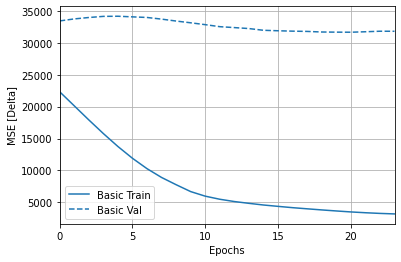

In [ ]:
print(history.history.keys())
plotter.plot({'Basic': history}, metric = "mse")
#plt.ylim([38000, 50000])
plt.ylabel('MSE [Delta]')

Text(0, 0.5, 'MSE [Delta^2]')

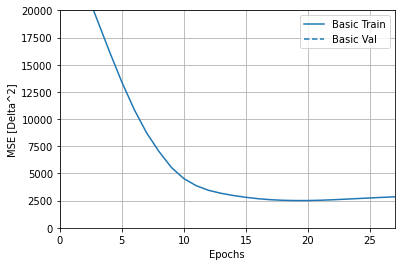

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20000])
plt.ylabel('MSE [Delta^2]')

**These two graphs look like classic examples of underfitting when the model does not have the complexity for the dataset so I'll have to change the model used.**

In [ ]:
loss, mae, mse = model.evaluate(test_data, test_label, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} %".format(mae))

3/3 - 0s - loss: 23212.6152 - mae: 92.3181 - mse: 23212.6152
Testing set Mean Abs Error: 92.32 %


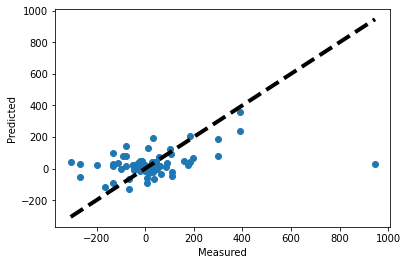

In [ ]:
predicted = model.predict(test_data)

fig, ax = plt.subplots()
ax.scatter(test_label, predicted)
ax.plot([test_label.min(), test_label.max()], [test_label.min(), test_label.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



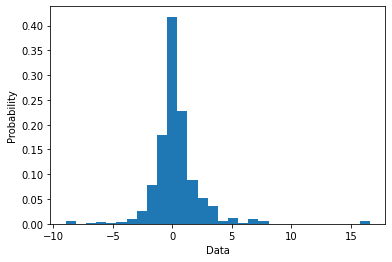

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
x = data['Delta']
plt.hist(x, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

Yep, that's an ugly histogram. I'll be fixing that shortly. Probably should have looked at the earlier while I was processing it. This is obvious thinking back to it because the values are going to be centered around zero. My next step is to try to scrape even more articles and then see if I have enough to get a subset with a flatter histogram.

In [ ]:
import statistics 
statistics.stdev(data['Delta'])

2.083339478251333